In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [16]:
def lotka_volterra(t, state, params):
    """
    Fonction qui définit le système d'équations de Lotka-Volterra
    dx/dt = alpha*x - beta*x*y
    dy/dt = delta*x*y - gamma*y
    
    Paramètres:
    t : temps (non utilisé ici mais nécessaire pour certains solveurs)
    state : vecteur [x, y] où x est la population de proies (lapins) et y est la population de prédateurs (renards)
    params : (alpha, beta, delta, gamma) - paramètres du modèle
    """
    x, y = state
    alpha, beta, delta, gamma = params
    
    dx_dt = alpha * x - beta * x * y
    dy_dt = delta * x * y - gamma * y
    
    return np.array([dx_dt, dy_dt])

In [26]:
def euler_method(f, y0, t_span, params, num_points=1000):
    t_initial, t_final = t_span
    t = np.linspace(t_initial, t_final, num_points)
    dt = (t_final - t_initial) / (num_points - 1)
    
    y = np.zeros((num_points, len(y0)))
    y[0] = y0
    
    for i in range(1, num_points):
        derivatives = f(t[i-1], y[i-1], params)
        y[i] = y[i-1] + dt * derivatives
        
        # Empêcher les valeurs négatives
        y[i] = np.maximum(y[i], 0)
        
        # Vérifier s'il y a explosion numérique
        if np.any(np.isnan(y[i])) or np.any(np.abs(y[i]) > 1e6):
            return t[:i], y[:i]  # Retourner les résultats jusqu'à l'instabilité
    
    return t, y

In [ ]:
def load_data(filename):
    """Charger les données réelles"""
    df = pd.read_csv(filename)
    return df

In [25]:
def compute_mse(predictions, targets):
    """Calculer l'erreur quadratique moyenne avec gestion des cas spéciaux"""
    if predictions.shape != targets.shape:
        # Si les formes ne correspondent pas (par exemple à cause d'une instabilité)
        return float('inf')
    
    # Calculer le MSE
    squared_diff = (predictions - targets) ** 2
    
    # Vérifier s'il y a des NaN
    if np.any(np.isnan(squared_diff)):
        return float('inf')
    
    return np.mean(squared_diff)

In [28]:
def grid_search(data, param_ranges, num_days=1000):
    # Extraction des données initiales
    initial_rabbits = data.iloc[0]['lapin']
    initial_foxes = data.iloc[0]['renard']
    y0 = np.array([initial_rabbits, initial_foxes])
    
    # Extraction des valeurs réelles
    real_rabbits = data['lapin'].values
    real_foxes = data['renard'].values
    real_values = np.column_stack((real_rabbits, real_foxes))
    
    # Initialisation
    best_params = None
    best_mse = float('inf')
    best_predictions = None
    
    # Paramètres plus simples à tester d'abord
    alpha_values = [0.01, 0.05, 0.1, 0.2]
    beta_values = [0.001, 0.005, 0.01, 0.02]  
    delta_values = [0.001, 0.005, 0.01, 0.02]
    gamma_values = [0.1, 0.2, 0.3, 0.4]
    
    print("Valeurs initiales:", initial_rabbits, initial_foxes)
    
    total = len(alpha_values) * len(beta_values) * len(delta_values) * len(gamma_values)
    count = 0
    
    for alpha in alpha_values:
        for beta in beta_values:
            for delta in delta_values:
                for gamma in gamma_values:
                    count += 1
                    print(f"Test {count}/{total}: params=({alpha}, {beta}, {delta}, {gamma})")
                    
                    params = (alpha, beta, delta, gamma)
                    
                    try:
                        # Simulation avec les paramètres actuels
                        t, y = euler_method(lotka_volterra, y0, [0, num_days-1], params, num_points=len(data))
                        
                        # Vérifier si la simulation s'est terminée prématurément à cause d'instabilités
                        if len(y) < len(real_values):
                            print(f"Simulation instable, s'est arrêtée après {len(y)} pas")
                            continue
                            
                        # Calcul de l'erreur
                        mse = compute_mse(y, real_values)
                        
                        print(f"MSE={mse}")
                        
                        # Mise à jour des meilleurs paramètres
                        if mse < best_mse and not np.isinf(mse) and not np.isnan(mse):
                            best_mse = mse
                            best_params = params
                            best_predictions = y
                            print(f"Nouveaux meilleurs paramètres: {best_params}, MSE: {best_mse}")
                    except Exception as e:
                        print(f"Erreur avec les paramètres {params}: {e}")
    
    if best_params is None:
        print("ATTENTION: Aucun paramètre valide trouvé!")
        # Retourner des valeurs par défaut pour éviter l'erreur
        return (0.01, 0.001, 0.001, 0.1), float('inf'), np.zeros((len(data), 2))
        
    return best_params, best_mse, best_predictions

Valeurs initiales: 1000 2000
Test 1/256: params=(0.01, 0.001, 0.001, 0.1)
MSE=1015521.6526800751
Nouveaux meilleurs paramètres: (0.01, 0.001, 0.001, 0.1), MSE: 1015521.6526800751
Test 2/256: params=(0.01, 0.001, 0.001, 0.2)
MSE=1029645.1071298661
Test 3/256: params=(0.01, 0.001, 0.001, 0.3)
MSE=1035544.3425728362
Test 4/256: params=(0.01, 0.001, 0.001, 0.4)
MSE=1038683.250509032
Test 5/256: params=(0.01, 0.001, 0.005, 0.1)
MSE=1198611.829901286
Test 6/256: params=(0.01, 0.001, 0.005, 0.2)
MSE=1120959.0818629018
Test 7/256: params=(0.01, 0.001, 0.005, 0.3)
MSE=1099051.458038333
Test 8/256: params=(0.01, 0.001, 0.005, 0.4)
MSE=1089006.8305316118
Test 9/256: params=(0.01, 0.001, 0.01, 0.1)
MSE=1901158.761954115
Test 10/256: params=(0.01, 0.001, 0.01, 0.2)
MSE=1485101.5502791964
Test 11/256: params=(0.01, 0.001, 0.01, 0.3)
MSE=1354905.9406054984
Test 12/256: params=(0.01, 0.001, 0.01, 0.4)
MSE=1292536.305559837
Test 13/256: params=(0.01, 0.001, 0.02, 0.1)
MSE=4885199.994480825
Test 14/256:

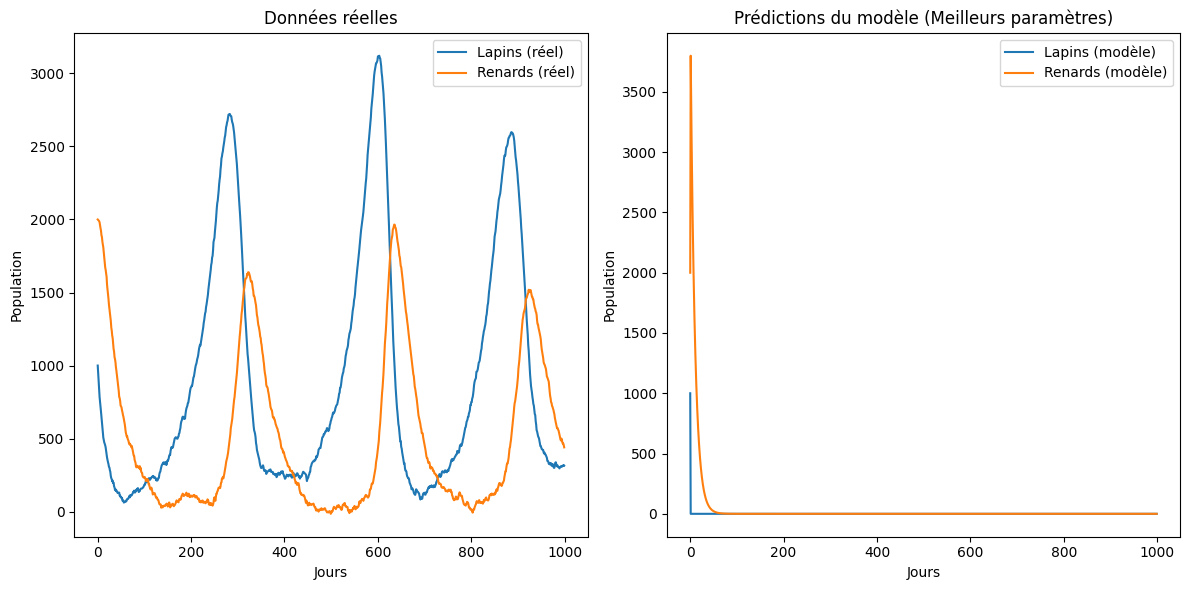

In [30]:
best_params, best_mse, best_predictions = grid_search(data, param_ranges)

# Affichage des résultats
print(f"Meilleurs paramètres : alpha={best_params[0]}, beta={best_params[1]}, delta={best_params[2]}, gamma={best_params[3]}")
print(f"Meilleure MSE : {best_mse}")

# Visualisation des résultats
plt.figure(figsize=(12, 6))

# Données réelles
plt.subplot(1, 2, 1)
plt.plot(data['lapin'], label='Lapins (réel)')
plt.plot(data['renard'], label='Renards (réel)')
plt.title('Données réelles')
plt.xlabel('Jours')
plt.ylabel('Population')
plt.legend()

# Prédictions du modèle
plt.subplot(1, 2, 2)
if best_predictions is not None and not np.isinf(best_mse):
    plt.plot(best_predictions[:, 0], label='Lapins (modèle)')
    plt.plot(best_predictions[:, 1], label='Renards (modèle)')
    plt.title('Prédictions du modèle (Meilleurs paramètres)')
else:
    plt.text(0.5, 0.5, "Pas de prédictions valides trouvées", 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)
plt.xlabel('Jours')
plt.ylabel('Population')
plt.legend()

plt.tight_layout()
plt.show()